In [ ]:
!pip install opencv-contrib-python

In [ ]:
# import the necessary packages
import numpy as np
import time
import cv2
import os

In [ ]:
!wget "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"

--2022-04-12 16:57:27--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘coco.names’

coco.names          100%[===================>]     625  --.-KB/s    in 0s      

2022-04-12 16:57:27 (31.2 MB/s) - ‘coco.names’ saved [625/625]



In [ ]:
!wget "https://pjreddie.com/media/files/yolov3.weights"
!wget "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"

--2022-04-12 16:57:33--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  57.5MB/s    in 4.4s    

2022-04-12 16:57:37 (53.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2022-04-12 16:57:38--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      


In [ ]:
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold

In [ ]:
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join(["/content","coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")
 
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

In [ ]:
LABELS[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

In [ ]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join(["/content", "yolov3.weights"])
configPath = os.path.sep.join(["/content", "yolov3.cfg"])
 
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet('/content/yolov3.cfg', '/content/yolov3.weights')
#net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [ ]:
# load our input image and grab its spatial dimensions
img = cv2.imread("/content/YOLO_test.jpg")
(Height, Weight) = img.shape[:2]
 
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
 
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
 
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

AttributeError: ignored

In [ ]:
# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

In [ ]:
# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
 
		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > confThreshold:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([Weight, Height, Weight, Height])
			(centerX, centerY, width, height) = box.astype("int")
 
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
 
			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

In [ ]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)

(-0.5, 799.5, 529.5, -0.5)

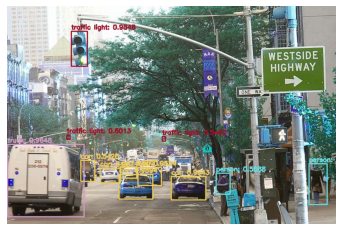

In [ ]:
from matplotlib import pyplot as plt
# ensure at least one detection exists
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
 
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
			0.5, color, 2)
 
# show the output image
plt.imshow(img)
plt.axis("off")
